# BUAI 446 - Homework 2
# Detecting COVID-19 from Chest CT Scans


As the Coronavirus Disease 2019 (COVID-19) pandemic continues to challenge many countries around the world, testing to detect COVID-19 and isolating individuals who test positive remains a crucial strategy for preventing community spread of the disease. In this context, automatic and accurate detection of COVID-19 using medical imaging modalities, such as Computed Tomography (CT), can be beneficial as a diagnostic tool.

In this exercise, our goal is to develop Convolutional Neural Networks to automatically detect the subtle signs of COVID-19 infection in patients' lungs from CT images. Our dataset contains 1010 CT scans from individuals with COVID-19 and 1010 CT scans from patients with other pulmonary diseases (non-COVID-19). These data have been collected from real patients in hospitals from Sao Paulo, Brazil. 

Our training and validation sets include 1600 and 420 CT images, respectively (half COVID-19, half non-COVID-19). Given the small size of the original dataset, I did not set aside any images for the test set. We will use the validation accuracy to evaluate our models. This is OK since we are not going to use the validation performance as a feedback signal to fine tune the hyperparameters of our models. 

Your task is to classify the images correctly by building multiple CNNs and comparing their performance.

Here are what a few of the CT images look like:

![ct-covid](https://www.dropbox.com/s/r9lld9dj7875rsw/ct-covid.jpg?dl=1)


## Note on training time

I recommend you train your CNNs on GPU for faster training. To do so, from the Runtime tab above, go to Change runtime type and select GPU as Hardware accelerator. Training time of each model may take up to an hour on GPU (longer on CPU), so please be patient.

## Load the data

First, add the `covid19_ct` folder from [here](https://drive.google.com/drive/folders/11-2z9P45FtJJPm9LbipVMAnNZ36kMQUH) to your Google Drive. For example, you can drag and drop the `covid19_ct` folder into your "My Drive"; this will add a shortcut to the original folder in your "My Drive". By doing so, you can run your code directly on the data that are stored on my Google Drive account without the need to download the images and upload them to your Drive. 

Mount your Google Drive and load the data. Be sure to change the directory path provided below to your own data path.

In [ ]:
# Mount the drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# The first time that you run this cell, you will need to authorize access in your drive. 

Mounted at /content/drive


In [ ]:
# Define directories of where the training and validation sets reside
base_dir = '/content/drive/My Drive/Data/CNN_Datasets/covid19_ct'
# This is the path to where my files are - your path will be different

In [ ]:
import os

train_dir = os.path.join(base_dir, 'Train')
validation_dir = os.path.join(base_dir, 'Validation')

# Training Data
train_covid  = os.path.join(train_dir, 'COVID')
train_noncovid     = os.path.join(train_dir, 'non-COVID')

# Validation Data
val_covid  = os.path.join(validation_dir, 'COVID')
val_noncovid     = os.path.join(validation_dir, 'non-COVID')


Use the code below to check how many images are available for each class in the training and validation sets.

In [ ]:
print('Total training covid images:', len(os.listdir(train_covid)))
print('Total training noncovid images:', len(os.listdir(train_noncovid)))

Total training covid images: 800
Total training noncovid images: 800


In [ ]:
print('Total validation covid images:', len(os.listdir(val_covid)))
print('Total validation noncovid images:', len(os.listdir(val_noncovid)))

Total validation covid images: 210
Total validation noncovid images: 210


## Question 1. Build a simple CNN from scratch (50 pts)

Build a simple CNN. Include 3 convolution and 3 max-pooling layers. In convolution layers 1, 2, and 3, include 32, 64, and 64 filters, respectively. Use 3x3 filters, 2x2 pooling windows, and ReLU activation functions. Please use an input shape of 64x64 and note that while these images look like greyscale images, they are in fact color images. Include a dense layer with 128 nodes on top along with an appropriate output layer. Compile the model using `RMSProp` optimizer and use a learning rate of `0.00005`. Follow the `accuracy` metric during training. (hint: if you do not recall how to change the default learning rate of your optimizer, check out Module 1 slides.)

For data preprocessing, please use the `ImageDataGenerator` tool in Keras. Create `train_datagen` and `validation_datagen` generators that rescale the images appropriately. Do not do any data augmentation in your first model (that will come next!) 
Then, define a training set generator and validation set generator using the generators `train_datagen` and `validation_datagen` and the `.flow_from_directory` method. Specify the `target_size` (it should match the input size above), set the `batch_size` to 32 and choose an appropriate `class_mode`. Train the model for 50 epochs. 

When training is complete, plot the training and validation loss and accuracy. Interpret your plots. Does the model seem to be overfitting? Explain why / why not.

In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers

# Build the model
model1 = models.Sequential()

model1.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model1.add(layers.MaxPooling2D((2, 2)))

model1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model1.add(layers.MaxPooling2D((2, 2)))

model1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model1.add(layers.MaxPooling2D((2, 2)))

model1.add(layers.Flatten())

model1.add(layers.Dense(128, activation='relu'))
model1.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2304)              0

In [ ]:
from tensorflow.keras import optimizers

model1.compile(loss='binary_crossentropy',
               optimizer=optimizers.RMSprop(learning_rate=0.00005),
               metrics=['accuracy'])

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(64, 64),
        batch_size=32,
        class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(64, 64),
        batch_size=32,
        class_mode='binary')

Found 1600 images belonging to 2 classes.
Found 420 images belonging to 2 classes.


In [ ]:
model1_history = model1.fit(
      train_generator,
      epochs=50,
      validation_data=validation_generator)

Epoch 1/50
50/50 [==============================] - 868s 17s/step - loss: 0.6818 - accuracy: 0.5606 - val_loss: 0.6603 - val_accuracy: 0.6976
Epoch 2/50
50/50 [==============================] - 11s 223ms/step - loss: 0.6552 - accuracy: 0.6569 - val_loss: 0.6209 - val_accuracy: 0.7738
Epoch 3/50
50/50 [==============================] - 11s 223ms/step - loss: 0.6233 - accuracy: 0.6888 - val_loss: 0.5736 - val_accuracy: 0.7952
Epoch 4/50
50/50 [==============================] - 11s 226ms/step - loss: 0.5950 - accuracy: 0.7156 - val_loss: 0.5364 - val_accuracy: 0.7952
Epoch 5/50
50/50 [==============================] - 11s 227ms/step - loss: 0.5708 - accuracy: 0.7181 - val_loss: 0.5135 - val_accuracy: 0.7762
Epoch 6/50
50/50 [==============================] - 11s 228ms/step - loss: 0.5486 - accuracy: 0.7369 - val_loss: 0.4818 - val_accuracy: 0.7952
Epoch 7/50
50/50 [==============================] - 11s 226ms/step - loss: 0.5321 - accuracy: 0.7437 - val_loss: 0.4725 - val_accuracy: 0.8024


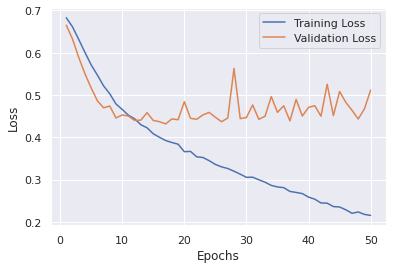

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

train_loss1 = model1_history.history['loss']
val_loss1 = model1_history.history['val_loss']
train_acc1  = model1_history.history['accuracy']
val_acc1  = model1_history.history['val_accuracy']

epochs = range(1, len(train_loss1) + 1)

plt.plot(epochs, train_loss1, label = 'Training Loss')
plt.plot(epochs, val_loss1, label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

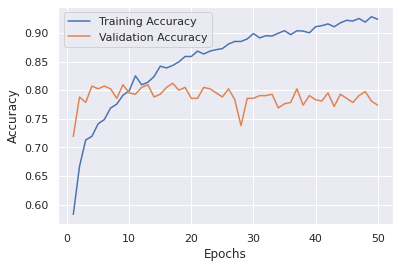

In [ ]:
plt.plot(epochs, train_acc1, label = 'Training Accuracy')
plt.plot(epochs, val_acc1, label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In my case, the model overfits after about 19 epochs based on the graph above (the validation loss starts to increase after 19 epochs). This is not surprising given the small size of the training dataset. Please note that your graphs will be slightly different than mine due to random initialization of the filter weights and biases. 

## Question 2. Use transfer learning and data augmentation to improve your CNN (50 pts)

Use one of the pre-trained models in Keras that has been trained on the ImageNet dataset (e.g., VGG16) as your convolutional base. Add a densly-connected layer and an output layer with the same number of neurons and the same activation functions as in your previous model to this convolutional base. Make sure to freeze the convolutional base so that the pre-trained weights and biases do not change during the training process of the new densly-connected classifier. Compile the model using `RMSProp` optimizer and use a learning rate of `0.00005`. Follow the `accuracy` metric during training. 

For data preprocessing, please use the `ImageDataGenerator` tool in Keras. This time use the tool to do data augmentation. You are free to choose the type of transformations made to the training images, or you can just use the same data augmentation parameters we used in class for the cat vs. dog example. Keep the same target size and batch size as your previous model. 
Train your model for 100 epochs. 

When training is complete, plot the training and validation loss and accuracy. Interpret your plots. Does the model seem to be overfitting? Explain why / why not.

Compare the validation loss and accuracy of the two models you developed in this notebook. Which model would you choose to detect COVID-19 from chest CT images? 

In [ ]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(64, 64, 3))

In [ ]:
model2 = models.Sequential()

model2.add(conv_base)

model2.add(layers.Flatten())

model2.add(layers.Dense(128, activation='relu'))
model2.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model2.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 2, 2, 512)         14714688  
_________________________________________________________________
flatten_16 (Flatten)         (None, 2048)              0         
_________________________________________________________________
dense_32 (Dense)             (None, 128)               262272    
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 129       
Total params: 14,977,089
Trainable params: 14,977,089
Non-trainable params: 0
_________________________________________________________________


In [ ]:
conv_base.trainable = False

In [ ]:
from tensorflow.keras import optimizers

model2.compile(loss='binary_crossentropy',
               optimizer=optimizers.RMSprop(learning_rate=0.00005),
               metrics=['accuracy'])

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(
                rescale=1./255,
                rotation_range=40,
                width_shift_range=0.2,
                height_shift_range=0.2,
                shear_range=0.2,
                zoom_range=0.2,
                horizontal_flip=True)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(64, 64),
        batch_size=32,
        class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(64, 64),
        batch_size=32,
        class_mode='binary')

Found 1600 images belonging to 2 classes.
Found 420 images belonging to 2 classes.


In [ ]:
model2_history = model2.fit(
      train_generator,
      epochs=100,
      validation_data=validation_generator)

Epoch 1/100
50/50 [==============================] - 11s 223ms/step - loss: 0.6346 - accuracy: 0.6450 - val_loss: 0.5747 - val_accuracy: 0.7500
Epoch 2/100
50/50 [==============================] - 11s 220ms/step - loss: 0.5589 - accuracy: 0.7362 - val_loss: 0.5301 - val_accuracy: 0.7690
Epoch 3/100
50/50 [==============================] - 11s 217ms/step - loss: 0.5125 - accuracy: 0.7631 - val_loss: 0.4959 - val_accuracy: 0.7762
Epoch 4/100
50/50 [==============================] - 11s 218ms/step - loss: 0.4991 - accuracy: 0.7650 - val_loss: 0.4839 - val_accuracy: 0.7833
Epoch 5/100
50/50 [==============================] - 11s 216ms/step - loss: 0.4879 - accuracy: 0.7669 - val_loss: 0.4695 - val_accuracy: 0.7905
Epoch 6/100
50/50 [==============================] - 11s 218ms/step - loss: 0.4641 - accuracy: 0.7850 - val_loss: 0.4937 - val_accuracy: 0.7810
Epoch 7/100
50/50 [==============================] - 11s 220ms/step - loss: 0.4660 - accuracy: 0.7819 - val_loss: 0.4640 - val_accuracy:

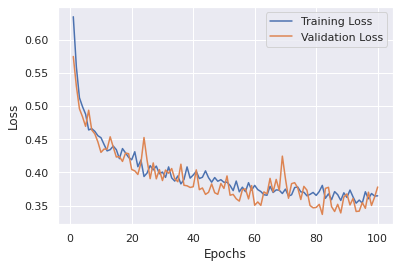

In [ ]:
train_loss2 = model2_history.history['loss']
val_loss2 = model2_history.history['val_loss']
train_acc2  = model2_history.history['accuracy']
val_acc2  = model2_history.history['val_accuracy']

epochs = range(1, len(train_loss2) + 1)

plt.plot(epochs, train_loss2, label = 'Training Loss')
plt.plot(epochs, val_loss2, label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

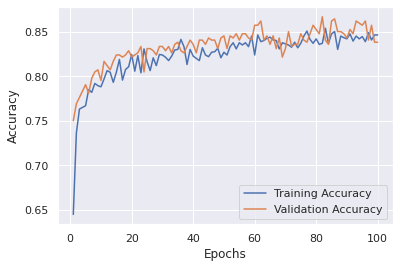

In [ ]:
plt.plot(epochs, train_acc2, label = 'Training Accuracy')
plt.plot(epochs, val_acc2, label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

Based on the graphs above, the model does not seem to overfit. The validation curve follows the training curve closely. Using transfer learning and data augmentation has been helpful to prevent overfitting and to improve the performance of the model. 

To choose between the two models, we can compare their validation loss and accuracy head to head. 

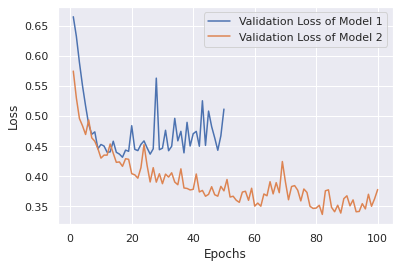

In [ ]:
x1 = range(1, len(val_loss1) + 1)
x2 = range(1, len(val_loss2) + 1)

plt.plot(x1, val_loss1, label = 'Validation Loss of Model 1')
plt.plot(x2, val_loss2, label = 'Validation Loss of Model 2')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

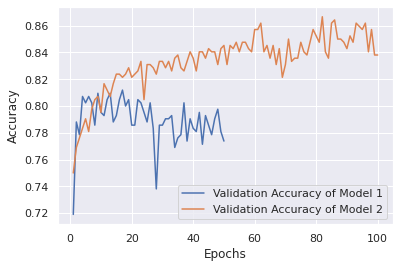

In [ ]:
x1 = range(1, len(val_acc1) + 1)
x2 = range(1, len(val_acc2) + 1)

plt.plot(x1, val_acc1, label = 'Validation Accuracy of Model 1')
plt.plot(x2, val_acc2, label = 'Validation Accuracy of Model 2')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

As we can see, our first model has an accuracy of around 78%-80%. Our second model has an accuracy of around 84%-86%. The second model also has a smaller validation loss and does not overfit. Therefore, we are going to select the **second model** to detect COVID-19 from chest CT images.